<a href="https://colab.research.google.com/github/rnrrmr/image-classification/blob/main/weather_classification_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil

datagen = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=120,  # randomly rotate images in the range (degrees)
    width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
    validation_split=0.2
)

# 데이터 디렉토리 경로
data_dir = "/content/drive/MyDrive/weather-dataset/dataset"
batch_size = 32

# 테스트 데이터 폴더 생성
test_data_dir = "/content/drive/MyDrive/weather-dataset/test_data"
# os.makedirs(test_data_dir, exist_ok=True) # 만들었음

# # 테스트 데이터로 사용할 이미지를 해당 폴더로 복사 또는 이동
# class_folders = os.listdir(data_dir)
# for class_folder in class_folders:
#     class_path = os.path.join(data_dir, class_folder)
#     images = os.listdir(class_path)

#     # 테스트 데이터로 사용할 이미지를 선택하여 복사 또는 이동
#     # 예: 데이터 중 10%를 테스트 데이터로 사용
#     num_test_images = int(0.1 * len(images))
#     test_images = images[:num_test_images]

#     # 테스트 데이터 폴더로 이미지 복사 또는 이동
#     for img in test_images:
#         src = os.path.join(class_path, img)
#         dest = os.path.join(test_data_dir, class_folder, img)
#         shutil.copy(src, dest)

# 학습용 데이터 로드
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # 이미지 크기를 조정
    batch_size=batch_size,
    class_mode='categorical',  # 다중 클래스 분류를 위한 설정
    subset='training'  # 학습 데이터로 설정
)
# 검증용 데이터 로드
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 검증 데이터로 설정
)

Found 5493 images belonging to 11 classes.
Found 1369 images belonging to 11 classes.


In [ ]:
class_labels = os.listdir(data_dir)
print(class_labels)  # 클래스 라벨 확인

['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


In [ ]:
# 모델 정의
model = keras.Sequential(name="weather-classification")

# 입력 레이어 (224x224 크기의 RGB 이미지)
model.add(keras.layers.Input(shape=(224, 224, 3))) # 채널(색상) 수가 3(RGB)

# 컨볼루션 레이어 (첫 번째 블록)
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')) # padding 'same'으로 설정하면 입력 이미지와 출력 이미지의 크기를 동일하게 유지하려고 시도
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')) # 이미지 가장자리에 있는 정보를 보존하는 데 도움
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')) # stride 높이와 너비에 따른 컨볼루션의 보폭을 지정하는 정수 또는 2개의 정수로 구성된 튜플

# 컨볼루션 레이어 (두 번째 블록)
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))  # 맥스 풀링 레이어는 특성 맵을 다운샘플링하여 공간 차원을 줄입니다. 이 과정은 이미지 크기를 반으로 줄입니다

# 컨볼루션 레이어 (세 번째 블록)
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))  # VGG16 아키텍처의 특징, 블록마다 컨볼루션 레이어로 특징을 추출하고 맥스 풀링 레이어로 공간 크기를 줄여 깊은 특성을 학습

# 컨볼루션 레이어 (네 번째 블록)
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# 컨볼루션 레이어 (다섯 번째 블록)
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

# 글로벌 평균 풀링 레이어
model.add(keras.layers.GlobalAveragePooling2D())

# 완전 연결 레이어 (분류 레이어)
model.add(keras.layers.Dense(11, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 요약
model.summary()


Model: "weather-classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 

In [ ]:
model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/20
172/172 [==============================] - 1024s 6s/step - loss: 5.4440 - accuracy: 0.1830 - val_loss: 1.8749 - val_accuracy: 0.2966
Epoch 2/20
172/172 [==============================] - 135s 782ms/step - loss: 1.8267 - accuracy: 0.3308 - val_loss: 1.6667 - val_accuracy: 0.3996
Epoch 3/20
172/172 [==============================] - 138s 804ms/step - loss: 1.6309 - accuracy: 0.4103 - val_loss: 1.6527 - val_accuracy: 0.4368
Epoch 4/20
172/172 [==============================] - 153s 889ms/step - loss: 1.5535 - accuracy: 0.4449 - val_loss: 1.5719 - val_accuracy: 0.4244
Epoch 5/20
172/172 [==============================] - 136s 791ms/step - loss: 1.4722 - accuracy: 0.4722 - val_loss: 1.4188 - val_accuracy: 0.4989
Epoch 6/20
172/172 [==============================] - 154s 893ms/step - loss: 1.4087 - accuracy: 0.4990 - val_loss: 1.4286 - val_accuracy: 0.5018
Epoch 7/20
172/172 [==============================] - 135s 785ms/step - loss: 1.8148 - accuracy: 0.3894 - val_loss: 1.8161 - v

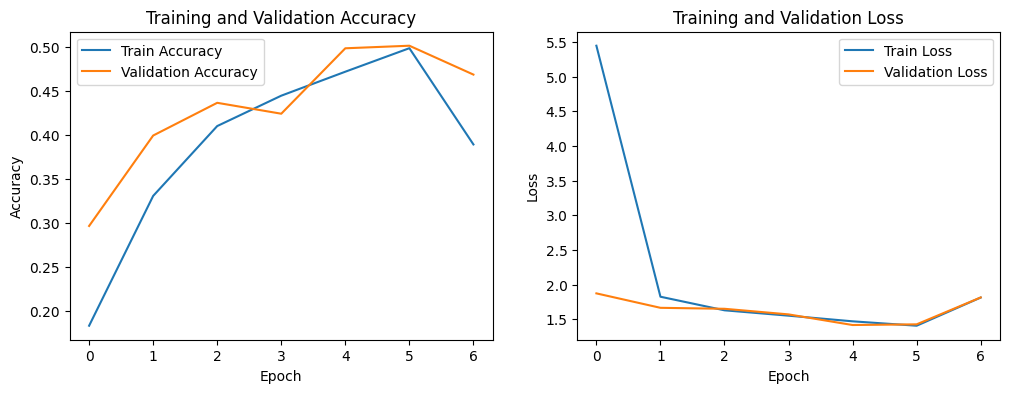

In [ ]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실값 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    # 이미지 불러오기 및 전처리
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1, 224, 224, 3)
    image = preprocess_input(image)

    # 모델로 예측 수행
    preds = model.predict(image)

    # 클래스 인덱스와 예측 확률 추출
    predicted_class_index = np.argmax(preds)

    # 클래스명 가져오기
    predicted_class = class_labels[predicted_class_index]

    # 이미지 시각화
    show_image(image_path)

    # 예측 결과 출력
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: {predicted_class}")
    print(f"Probability: {preds[0][predicted_class_index]*100:.3f}%")

    return preds


In [ ]:
# 테스트용 데이터 로드
test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # 이미지 값을 [0, 1] 범위로 정규화

test_data_dir = "/content/drive/MyDrive/weather-dataset/test_data"

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(160, 160),  # 이미지 크기를 조정 (학습과 동일한 크기로 설정)
    batch_size=batch_size,  # 배치 크기는 학습과 동일하게 설정
    class_mode='categorical',  # 다중 클래스 분류
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test accuracy:", test_accuracy)


Found 1064 images belonging to 11 classes.
34/34 [==============================] - 136s 4s/step - loss: 5.0456 - accuracy: 0.0648
Test accuracy: 0.0648496225476265


In [ ]:
make_predictions("/content/drive/MyDrive/weather-dataset/weather_sample/image2.jpg")

In [ ]:
make_predictions("/content/drive/MyDrive/weather-dataset/weather_sample/image9.jpg")

In [ ]:
make_predictions("/content/drive/MyDrive/weather-dataset/weather_sample/image11.jpg")

In [ ]:
make_predictions("/content/drive/MyDrive/weather-dataset/weather_sample/image5.jpg")